# Testing the Efficient Market Hypothesis as Applied to Bitcoin by Designing a Double Deep Q-Learning Trading Agent

## 1. Introduction

The Efficient Market Hypothesis (EMH) stipulates that asset prices reflect all available information. Therefore, a direct implication of this is that it is impossible to beat the market consistently on a risk-adjusted basis. 

Markets are considered to be the most effective way of aggregating information disperesed within a society. Self interested traders are incentivised to acquire private information and act based on this to return a profit. In the competitive limit of such actions, traders contribute towards a more efficient price reflecting the available information. 

The Random Walk Hypothesis, which stipulates that successive prices changes are independent, identically distributed random variables, is often cited in support of the EMH. Indeed, Samuelson published a proof showing that if markets are efficient, then the price behaviour will demonstrate a random walk [1]. Eugene Fama demonstrates support for the random walk hypothesis by empirical tests using stock data from the Dow-Jones Industrial Average [2]. He explicitly notes, "This implies, of course, that chart reading (technical analysis), though perhaps an interesting pastime, is of no real value to the stock market investor".


In Fama's later seminal review paper, he categorizes the efficient market hypothesis into a "weak from", "semi-strong form" and "strong form", with each category reflecting the level of information that assert prices reflect [3]. The weak from of the hypothesis is the most conservative and establishes that historical asset prices do not provide information of future price development, as the information is already taken into account in the current price for any instance. 


Some critics of the EMH attribute market imperfections to cognitive biases studied in behavioral economics, such as overreaction, overconfidence and representative biases. The weak form of the EMH is more likely to hold true in well established markets such as S&P 500, Dow-Jones Industrial Average stocks and major currency pairs, where sophisticated institutional investors dominate the majority of market volume and compete to exploit any useful pieces of informatiomn. However, in more nascent and retail driven markets, such as crypto currencies, even weaker forms of the EMH may not hold, as retail market participants are more inclined to commit classical behavioural biases in their trading activity. Of course, an algorithmic trading agent does not suffer from such biases and thus leaves the possibility of overperforming in these retail investor driven markets. Moreover, as Tshilidzi Marwala conjectures, the more artificial intelligence instilled trading agents there are in the market, the more efficient the market becomes [4]. By building a Double Deep Q-learning trading agent in the BTC/USD market, and investigating if consistent over-performing of the market is possible, we explore whether past returns can be used to predict future returns, and as such explore if the EMH does not apply for this largely retail investor driven market. 

Our research question has practical importance as some prevelant financial tools used for financial decision making (e.g. Capital Asset Pricing Model) rely on an assumption of efficient markets. Moreover, whether or not a market is efficient aids us in setting appropriate compensation levels for 'active portfolio' managers. For instance, assuming the stronger forms of the EMH, it seems inappropriate to reward a portfolio manager to outperform the market, as this would not be feasible. Furthermore, the degree to which the EMH holds can aid securities law enforcement by evaluating the likelihood of illegal activities, such as insider trading. For instance, under the semi-strong EMH, asset prices factor in all public information, but not private information. If a market is deemed semi-strong efficient, then the market's participants achieving consistent over-performance are perhaps acting with private information, which constitutes insider trading. Investigating the EMH for the BTC/USD market allows us to better understand when the hypothesis applies and fails, and for what reasons. These reasons may apply to other asset markets in varying degrees.


Hourly Bitcoin price open, high, low, close and volume data for the period 17/08/2017 to 04/04/2021 is used to craft technical analysis indicators (e.g. lagged returns, moving averages, Relative Strength Index and Bollinger Bands) and split into a training and testing dataset. These historical data based indicators are often used by 'chartist' to descern optimal market conditions for placing positions. The indicators are calculated for each hourly time period and are presented as part of the environment of the Deep Q-Network of the agent.

The environmnt is initialised to start at a random position in the training dataset time series. At each step, the environment proceeds an hour forward for 250 steps, reveals the next daily return and values of various technical indicators, and attributes a reward to the agent based on past decisions. Our agent may take one of three actions:

1.   **Short position:** Bet Bitcoin's price (in USD) will fall
2.   **Neutral position:** Hold USD only
3.   **Long position:** Invest and bet Bitcoin's price will increase

For each action, the agent will incur a trading cost defined as a percentage of the amount traded, as well as a holding cost for periods during which the agent holds a neutral position. These are implemeneted to mimick reality and to encourage the agent to take a stance on price movements (i.e. avoid neutral positions). The agent starts with capital, or Net Asset Value (NAV), of 1 unit and is benchmarked against a buy-and-hold strategy without holding costs reflecting the market and a random policy. The trading agent is based on and inspired by Stefan Jansen's Reinforcement Learning trading agent in his book "Machine Learning for Algorithmic Trading" [5].


Next, we proceed to discuss the methodology adopoted, covering the construction of the environment, data pre-processing, trading logic implementation and trading agent construction. Subsequently, we train our agent for approximately five hours and evaluate the performance on a test dataset against a buy-and-hold strategy and a random policy. Lastly, we provide conculding remarks.

## 2. Methodology

Here, we discuss the methodology of implementing the Double Deep Q-learning trading agent used to investigate the applicability of the EMH in the BTC/USD market. The setup can be composed into two parts: constructing the environment and the trading agent.

First in "2.1 Imports and Configuration" we install the necessary libraries, import the required packages and mount our google drive to acces the data, which is in csv format (See the Github repo for Binance_BTCUSD_1h.csv file). Secondly, within part "2.2 Data Processing and Feature Extraction" and "2.3 Trading Logic and Environment", we construct the environment. The environment is built using three different python classes: `DataSource`, `TradingLogic` and `TradingEnvironment`. After this, we construct our trading agent in "2.4 Define Trading Agent" within the class `TradingAgent`. We finally train it in part "2.5 Train and Validate".

We choose to adopt a setup in which the environment is built using various interconnected classes, as opposed to one class, to provide a standardised environment that is modular. Such a structure may be easily extended by editing one of the modular pieces (e.g. the trading logic or the data pre-processing).

### 2.1 Imports and Configuration

Install and import the necessary packages.

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip3 -q install gym
!pip3 -q install pyglet
!pip3 -q install pyopengl
!pip3 -q install pyvirtualdisplay
!apt install xvfb -y


from time import time
from collections import deque
from random import sample

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set_style('whitegrid')

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import gym
from gym import spaces

!pip install --upgrade ta
import ta

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
  Created wheel for ta: filename=ta-0.7.0-cp37-none-any.whl size=28716 sha256=63f401c1af46453e1d32db77ef6722c7a0eec91648e792811eacdc3921e0513a
  Stored in directory: /root/.cache/pip/wheels/dd/88/30/de9553fb54a474eb7480b937cdbb140bdda613d29cf4da7994
Successfully built ta


Mount your google drive into the runtime's virtual machine. Be sure to have the dataset "Binance_BTCUSD_1h.csv" within the directory pointed by the variable `url` (the dataset "Binance_BTCUSD_1h.csv" provided in Github repo).

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # When prompted, enter your authorization code
url = '/content/drive/MyDrive/Colab Notebooks' # save the Binance_BTCUSD_1h.csv file into the directory pointed by 'url' string

Mounted at /content/drive


### 2.2 Data Processing and Feature Extraction

The dataset used is the hourly time, price and volume data for Bitcoin with respect to USD for the time period 17/08/2017 to 04/04/2021 obtained from one of the world's largest Bitcoin exchanges, Binance. The dataset is downlaoded from Crypto Data Download [6]. We load the data, clean it, create additional technical indicator features and preprocess it within the python class `DataSource`. 


The imported raw data includes the following columns:

**Unix Timestamp** - This is the unix timestamp

**Date** - This timestamp is in NY EST Standard Time

**Symbol** - The symbol for which the timeseries data refers to (BTC/USD)

**Open** - Opening price of the time period

**High** - Highest price of the time period

**Low** - Lowest price of the time period

**Close** - Closing price of the time period

**Volume (Crypto)** - Volume in the transacted crypto currency

**Volume Base Ccy** - Volume in the base currency (USD)

**Trade Count** - This is the unique number of trades for the given time period

For our purposes, we only extract the 'Date', 'Open', 'High', 'Low', 'Close', 'Volume Base Ccy'. 


From the data we notice that from the beginning to 2020/08/01 23:00:00 the unix timestamp is given in seconds. From 2020/08/01 23:00:00 to 2020/11/20 07:00:00 inclusive, the date is given in both unix seconds and milliseconds. After this, the timestamp is continually given in milliseconds. For consistency, we convert all unix time stamps into a datetime format of 'YYYY-MM-DD HH:MM:SS'. 


Next, we choose relevant financial technical indicators to include as new features. Technical indicators are heuristics or pattern-based signals produced by historical prices (open, high, low, close) and volume data, which is used by traders to forecast price behaviour. There exists a variety of technical indicators capturing price momentum, volume, volatility and trend charateristics. The benefit of including many technical indicators as features, and thus the enviroment, is that this allows our agent to gain a richer set of information of the past price behaviour. However, as many of these indicators are capturing similar characteristics of the price behaviour, albeit through different methods, including too many technical indicators will add noise to the observation space. Therefore, to enrich the observation space with informative signals and avoid excessive noise, we pick the least correlated indicators within their respective groups. 


Taking the log of Bitcoin's price, we see a linear trend indicating that the data is non-stationary. However, the hourly percentage price changes appear to be stationary, therfore we use the hourly changes in price instead (see figures in "2.3.3 Initialize Trading Environment"). We include the hourly changes in price as well as the chosen technical indicators as features within the environment used by the agent.

Intrinsically ordered data, such as time series, can be problematic to cross-validate as there is a temporal dependence between observations that we must preserve. We split the time series data such that the chronologically earliest 70% is the training dataset and the last 30% is the test dataset.

#### 2.2.1 DataSource Class

The `DataSource` class implements the previously discussed data loading, cleaning and technical indicator feature construction. The class also maintains internal class variables representing where in the time-series data the environment is currently in. 

In [ ]:
class DataSource:
    '''    
    A class responsible for managing the data used for the environment.
    Loads the data, cleans it, creates technical indicators and preprocesses the data.
    Maintains the indices representing where in the time-series data the environment is currently in.
    '''
    def __init__(self, trading_hours=250):
        self.trading_hours = trading_hours                                  # trading hours is also number of steps in an episode
        self.train_proportion = 0.3                                         # train-test split proportion

        self.data = self.load_data()                                        # loads data from csv format and does preliminary cleaning
        self.indicators_list, self.indicators_df = self.get_indicators()    # returns a list of least correlated technical indicators and dataframe of all indicators
        self.preprocess_data()                                              # convert to non-stationary data and include features
        self.train_dataset, self.test_dataset = self.train_test_split()     # split time-series data to train and test

        self.min_values = self.data.min()
        self.max_values = self.data.max()

        self.step = 0                                                       # used to keep track of position in time-series data in the environment
        self.offset = None                                                  # used to initialise a new random position in training times-series data
        

    def load_data(self):
        """
        Load raw data from csv format and do preliminary cleaning. 
        Return a df.
        """
        col_names = ['unix','date','symbol','open','high','low','close','volume_btc', 'volume_usd', 'tradecount']
        df = pd.read_csv(f'{url}/Binance_BTCUSD_1h.csv', header=1, names=col_names)
        
        # index where unix time stamp changes from 's' to 'ms'
        k=3227                                                                                      
        
        # Data after the unix format reporting change
        aft_k_cleaned_data = df.iloc[:k,:] 
        # Data before the unix format reporting change
        bef_k_cleaned_data = df.iloc[k:,:][df.iloc[k:,:]['unix'] < 1e+10]                           # only select rows with unix time stamp given in seconds 

        aft_k_cleaned_data['date'] = pd.to_datetime(aft_k_cleaned_data['unix'], unit='ms')          # convert from unix ('ms') to datetime YYYY-MM-DD HH:MM:SS
        bef_k_cleaned_data['date'] = pd.to_datetime(bef_k_cleaned_data['unix'],unit='s')            # convert from unix ('s') to datetime YYYY-MM-DD HH:MM:SS

        columns = ['date', 'open', 'high', 'low', 'close', 'volume_usd']
        data = pd.concat([aft_k_cleaned_data.loc[:,columns], bef_k_cleaned_data.loc[:,columns]])    # re-compile the data before and after unix time stamp change
        data = data.sort_values('date', ascending=True).reset_index(drop=True)
        data.set_index('date', inplace=True)

        return data


    def get_indicators(self):
        '''
        Find momentum, volume, trend and volatility indicators that are least correlated within their group.
        Technical indicators are imported from ta library (https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html).
        We use the default parameter values of each technical indicator.
        Return a list of indicators chosen and the data df with time series of all indicator values included.
        '''
        # Compile a df of various momentum based indicators
        momentum_indicators = pd.DataFrame(
            {
                'RSI' : ta.momentum.RSIIndicator(self.data['close']).rsi(),
                'TSI' : ta.momentum.TSIIndicator(self.data['close']).tsi(),
                'UO' : ta.momentum.UltimateOscillator(self.data['high'], self.data['low'], self.data['close']).ultimate_oscillator(),
                'Stoch' : ta.momentum.stoch(self.data['high'], self.data['low'], self.data['close']),
                'Signal' : ta.momentum.stoch_signal(self.data['high'], self.data['low'], self.data['close']),
                'WR' : ta.momentum.williams_r(self.data['high'], self.data['low'], self.data['close']),
                'AO' : ta.momentum.AwesomeOscillatorIndicator(self.data['high'], self.data['low']).awesome_oscillator()
            }
            )

        # Compile a df of various volume based indicators
        volume_indicators = pd.DataFrame(
            {
                'ADI' : ta.volume.AccDistIndexIndicator(self.data['high'], self.data['low'], self.data['close'], self.data['volume_usd']).acc_dist_index(),
                'OBV' : ta.volume.OnBalanceVolumeIndicator(self.data['close'], self.data['volume_usd']).on_balance_volume(),
                'CMF' : ta.volume.chaikin_money_flow(self.data['high'], self.data['low'], self.data['close'], self.data['volume_usd']),
                'FI' : ta.volume.ForceIndexIndicator(self.data['close'], self.data['volume_usd']).force_index(),
                'EoM' : ta.volume.EaseOfMovementIndicator(self.data['high'], self.data['low'], self.data['volume_usd']).ease_of_movement(),
                'VPT' : ta.volume.VolumePriceTrendIndicator(self.data['close'], self.data['volume_usd']).volume_price_trend(),
                'NVI' : ta.volume.NegativeVolumeIndexIndicator(self.data['close'], self.data['volume_usd']).negative_volume_index()
            }
            )

        # Compile a df of various trend based indicators
        trend_indicators = pd.DataFrame(
            {
                'MACD' : ta.trend.MACD(self.data['close']).macd(),
                'MACD_signal' : ta.trend.MACD(self.data['close']).macd_signal(),
                'MACD_diff' : ta.trend.MACD(self.data['close']).macd_diff(),
                'EMA' : ta.trend.EMAIndicator(self.data['close']).ema_indicator(),
                'Vortex_pos' : ta.trend.VortexIndicator(self.data['high'],self.data['low'], self.data['close']).vortex_indicator_pos(),
                'Vortex_neg' : ta.trend.VortexIndicator(self.data['high'],self.data['low'],self.data['close']).vortex_indicator_neg(),
                'Vortex_diff' : ta.trend.VortexIndicator(self.data['high'],self.data['low'],self.data['close']).vortex_indicator_diff(),
                'Trix' : ta.trend.TRIXIndicator(self.data['close']).trix(),
                'CCI' : ta.trend.CCIIndicator(self.data['high'], self.data['low'], self.data['close']).cci(),
                'DPO' : ta.trend.DPOIndicator(self.data['close']).dpo(),
                'KST' : ta.trend.KSTIndicator(self.data['close']).kst(),
                'KST_sig' : ta.trend.KSTIndicator(self.data['close']).kst_sig(),
                'KST_diff' : ta.trend.KSTIndicator(self.data['close']).kst_diff(),
                'Ichimoku_a' : ta.trend.IchimokuIndicator(self.data['high'], self.data['low']).ichimoku_a(),
                'Ichimoku_b' : ta.trend.IchimokuIndicator(self.data['high'], self.data['low']).ichimoku_b(),
                'Aaron_up' : ta.trend.AroonIndicator(self.data['close']).aroon_up(),
                'Aroon_down' : ta.trend.AroonIndicator(self.data['close']).aroon_down(),
                'Aroon_ind' : ta.trend.AroonIndicator(self.data['close']).aroon_indicator()
            }
            )


        # Compile a df of various volatility based indicators
        volatility_indicators = pd.DataFrame(
            {
                'ATR' : ta.volatility.AverageTrueRange(self.data['high'],self.data['low'],self.data['close']).average_true_range(),
                'BBH' : ta.volatility.BollingerBands(self.data['close']).bollinger_hband(),
                'BBL' : ta.volatility.BollingerBands(self.data['close']).bollinger_lband(),
                'BBM' : ta.volatility.BollingerBands(self.data['close']).bollinger_mavg(),
                'KCH' : ta.volatility.KeltnerChannel(self.data['high'],self.data['low'],self.data['close']).keltner_channel_hband(),
                'KCL' : ta.volatility.KeltnerChannel(self.data['high'],self.data['low'],self.data['close']).keltner_channel_lband(),
                'DCH' : ta.volatility.DonchianChannel(self.data['high'],self.data['low'],self.data['close']).donchian_channel_hband(),
                'DCL' : ta.volatility.DonchianChannel(self.data['high'],self.data['low'],self.data['close']).donchian_channel_lband(),
                'DCM' : ta.volatility.DonchianChannel(self.data['high'],self.data['low'],self.data['close']).donchian_channel_mband(),
                'DCW' : ta.volatility.DonchianChannel(self.data['high'],self.data['low'],self.data['close']).donchian_channel_wband(),
            }
            )
        
        indicators = []
        momentum_indicators_dict = {}
        volume_indicators_dict = {}
        trend_indicators_dict = {}
        volatility_indicators_dict = {}

        # For each indicator, find the mean absolute correlation of the indicator with the other indicators within it's group
        for i, row in enumerate(momentum_indicators.corr().iterrows()):
            momentum_indicators_dict[momentum_indicators.columns[i]] = np.mean(abs(momentum_indicators.corr().iloc[i,:]).drop(momentum_indicators.columns[i]))
        for i, row in enumerate(volume_indicators.corr().iterrows()):
            volume_indicators_dict[volume_indicators.columns[i]] = np.mean(abs(volume_indicators.corr().iloc[i,:]).drop(volume_indicators.columns[i]))
        for i, row in enumerate(trend_indicators.corr().iterrows()):
            trend_indicators_dict[trend_indicators.columns[i]] = np.mean(abs(trend_indicators.corr().iloc[i,:]).drop(trend_indicators.columns[i]))
        for i, row in enumerate(volatility_indicators.corr().iterrows()):
            volatility_indicators_dict[volatility_indicators.columns[i]] = np.mean(abs(volatility_indicators.corr().iloc[i,:]).drop(volatility_indicators.columns[i]))

        # Select the two lowest correlated indicators from each group 
        indicators.extend(sorted(momentum_indicators_dict, key=lambda x: momentum_indicators_dict[x])[:2])
        indicators.extend(sorted(volume_indicators_dict, key=lambda x: volume_indicators_dict[x])[:2])
        indicators.extend(sorted(trend_indicators_dict, key=lambda x: trend_indicators_dict[x])[:2])
        indicators.extend(sorted(volatility_indicators_dict, key=lambda x: volatility_indicators_dict[x])[:2])

        # Time series df of all indicators (including the ones not selected)
        all_indicators_df = pd.concat([momentum_indicators, volume_indicators, trend_indicators, volatility_indicators], axis=1)

        return indicators, all_indicators_df


    def preprocess_data(self):
        '''
        Calculate percentage change in price with various lags and chosen technical indicators.
        Remove the original non-stationary features: open, high, low, close, volume_usd.
        Return a df.
        '''
        # Calculate various lags
        self.data['pct_change_1'] = self.data.close.pct_change()
        self.data['pct_change_5'] = self.data.close.pct_change(5)
        self.data['pct_change_10'] = self.data.close.pct_change(10)
        self.data['pct_change_20'] = self.data.close.pct_change(20)

        # Combine indicators previously chosen
        for indicator in self.indicators_list:
            self.data[indicator] = self.indicators_df[indicator]

        self.data = (self.data.replace((np.inf, -np.inf), np.nan)
                     .drop(['open', 'high', 'low', 'close', 'volume_usd'], axis=1)
                     .dropna())
        

    def train_test_split(self):
        """
        Split the whole data set into train and test sets according to 'train_proportion'
        """
        train_dataset = self.data.iloc[:int(len(self.data)*(1-self.train_proportion)),]
        test_dataset = self.data.iloc[int(len(self.data)*(1-self.train_proportion)):,]

        return train_dataset, test_dataset


    def reset(self):
        """
        Get the starting index for the time-series and reset 'self.step'.
        """
        high = len(self.train_dataset.index) - self.trading_hours
        self.offset = np.random.randint(low=0, high=high)
        self.step = 0


    def take_step(self):
        """
        Returns a row of data for the trading hour.
        """
        obs = self.train_dataset.iloc[self.offset + self.step].values
        self.step += 1
        done = self.step > self.trading_hours
        return obs, done 


    def take_step_test(self):
        """
        Sames as function above, but accounts for the test dataset not requiring an 'offset'
        """
        obs = self.test_dataset.iloc[self.step].values
        self.step += 1
        return obs, None

### 2.3 Trading Logic and Environment

The `TradingLogic` class implements the trading simulator and keeps record of various variables as an episode progresses (e.g. Net Asset Value, numbe of trades, past returns). 

In [ ]:
class TradingLogic:
    """ 
    Implements core trading logic.
    Keeps track of the Net Asset Value (NAV) and returns for the trading agent, market and random policy.
    Records the actions and positions taken and transaction and holding costs incurred.
    """
    def __init__(self, trading_hours, execution_cost, holding_cost, test_length, action_space):
        
        self.execution_cost = execution_cost    # cost of executing change (as a % of traded volume)
        self.holding_cost = holding_cost        # cost for doing nothing in a step (% of NAV)
        self.trading_hours = trading_hours      # length of an episode 
        self.test_length = test_length          # length of the test dataset
        self.possible_actions = action_space    # use 'possible_actions' to sampel random policy

        self.step = 0                                       # internal variable to keep track of process
        self.agent_actions = np.zeros(self.trading_hours)   # records the agent's actions taken
        self.random_actions = np.zeros(self.trading_hours)  # records the random policy's actions taken
        self.agent_navs = np.ones(self.trading_hours)       # records trading agents NAV across steps
        self.market_navs = np.ones(self.trading_hours)      # records markets NAV across steps as benchmark
        self.random_navs = np.ones(self.trading_hours)      # records random policy NAV across steps as benchmark
        self.agent_returns = np.ones(self.trading_hours)    # records returns realized by agent
        self.market_returns = np.zeros(self.trading_hours)  # records returns realized by market
        self.random_returns = np.zeros(self.trading_hours)  # records returns realized by random policy
        self.agent_positions = np.zeros(self.trading_hours) # records positions held by agent across time steps
        self.agent_costs = np.zeros(self.trading_hours)     # records costs (trading + holding) incurred by agent
        self.agent_trades = np.zeros(self.trading_hours)    # records quantity traded by agent across time steps
        self.random_positions = np.zeros(self.trading_hours)# records positions held by random policy across time steps
        self.random_costs = np.zeros(self.trading_hours)    # records costs (trading + holding) incurred by random policy
        self.random_trades = np.zeros(self.trading_hours)   # records quantity traded by random policy across time steps
        self.agent_cumulative_rewards = np.zeros(self.trading_hours)   # records the cumulative rewards obtained across time steps

    def reset(self, train=True):
        '''
        Resets all the internal recording variabls and 'self.step'
        '''
        if train:
            self.step = 0
            self.agent_actions.fill(0)
            self.random_actions.fill(0)
            self.agent_navs.fill(1)
            self.random_navs.fill(1)
            self.market_navs.fill(1)
            self.random_navs.fill(1)
            self.agent_returns.fill(0)
            self.market_returns.fill(0)
            self.random_returns.fill(0)
            self.agent_positions.fill(0)
            self.agent_costs.fill(0)
            self.agent_trades.fill(0)
            self.random_positions.fill(0)
            self.random_costs.fill(0)
            self.random_trades.fill(0)
            self.agent_cumulative_rewards.fill(0)
            
        else:
            # Re-initialize record keeping variables accounting for test dataset length
            self.step = 0
            self.agent_actions = np.zeros(self.test_length)
            self.random_actions = np.zeros(self.test_length)
            self.agent_navs = np.ones(self.test_length)
            self.market_navs = np.ones(self.test_length)
            self.random_navs = np.ones(self.test_length)
            self.agent_returns = np.ones(self.test_length)
            self.market_returns = np.zeros(self.test_length)
            self.random_returns = np.zeros(self.test_length)
            self.agent_positions = np.zeros(self.test_length)
            self.agent_costs = np.zeros(self.test_length)
            self.agent_trades = np.zeros(self.test_length)
            self.random_positions = np.zeros(self.test_length)
            self.random_costs = np.zeros(self.test_length)
            self.random_trades = np.zeros(self.test_length)
            self.agent_cumulative_rewards = np.zeros(self.test_length)
            
    def take_step(self, agent_action, market_return):
        """ 
        Calculates NAVs, trading costs and reward based on actions and market information for the time step.
        Action given as integer 0 to 2 (0 is 'Short', 1 is 'Neutral', 2 is 'Long').
        Returns the reward.
        """
        self.agent_actions[self.step] = agent_action
        random_action = self.possible_actions.sample() # sample a random action
        self.random_actions[self.step] = random_action
        
        self.market_returns[self.step] = market_return # record the observed market retunrs
        
        # Fetch the previous market positions
        agent_initial_position = self.agent_positions[max(0, self.step - 1)] 
        random_initial_position = self.random_positions[max(0, self.step - 1)] 
        
        # Retrieve initial NAVs for agent, market and random policy
        initial_agent_nav = self.agent_navs[max(0, self.step - 1)]
        initial_market_nav = self.market_navs[max(0, self.step - 1)]
        initial_random_nav = self.random_navs[max(0, self.step - 1)]

        # Re-scale actions from range 0 to 2 into range -1 to 1
        agent_end_position = agent_action - 1   
        random_end_position = random_action - 1 

        # Find quantity traded
        agent_quantity_traded = agent_end_position - agent_initial_position 
        random_quantity_traded = random_end_position - random_initial_position 

        # Record positions and quantity traded
        self.agent_positions[self.step] = agent_end_position
        self.agent_trades[self.step] = agent_quantity_traded
        self.random_positions[self.step] = random_end_position
        self.random_trades[self.step] = random_quantity_traded

        # Assign trading and holding costs
        agent_execution_costs = abs(agent_quantity_traded) * self.execution_cost
        agent_holding_costs = 0 if agent_action != 0 else self.holding_cost     # penalize for neutral position
        self.agent_costs[self.step] = agent_execution_costs + agent_holding_costs
        random_execution_costs = abs(random_quantity_traded) * self.execution_cost
        random_holding_costs = 0 if random_action != 0 else self.holding_cost   # penalize for neutral position
        self.random_costs[self.step] = random_execution_costs + random_holding_costs

        # Assign rewards for agent and random policy
        agent_reward = agent_initial_position * market_return - self.agent_costs[self.step]                   # reward as a percentage
        self.agent_returns[self.step] = agent_reward
        self.agent_cumulative_rewards[self.step] = agent_reward + self.agent_cumulative_rewards[self.step-1]  # record cumulative rewards of agent
        random_reward = random_initial_position * market_return - self.random_costs[self.step]                # reward as a percentage
        self.random_returns[self.step] = random_reward

        # Update NAVs (agent, market and random policy)
        if self.step != 0:
            self.agent_navs[self.step] = initial_agent_nav * (1 + self.agent_returns[self.step]) 
            self.market_navs[self.step] = initial_market_nav * (1 + self.market_returns[self.step])
            self.random_navs[self.step] = initial_random_nav * (1 + self.random_returns[self.step]) 

        self.step += 1

        return agent_reward

    def result(self):
        """
        Return all recording variables as a df.
        """
        return pd.DataFrame({'agent_nav'                : self.agent_navs,  
                             'agent_action'             : self.agent_actions, 
                             'agent_position'           : self.agent_positions,
                             'agent_cost'               : self.agent_costs,  
                             'agent_trade'              : self.agent_trades,
                             'agent_cumulative_reward'  : self.agent_cumulative_rewards,
                             'market_nav'               : self.market_navs,
                             'market_return'            : self.market_returns,
                             'random_nav'               : self.random_navs,  
                             'random_action'            : self.random_actions, 
                             'random_position'          : self.random_positions,
                             'random_cost'              : self.random_costs,  
                             'random_trade'             : self.random_trades})

#### 2.3.2 TradingEnvironment Class

The `TradingEnvironment` class ties togeather the `DataSource` and `TradingLogic` class to produce a comprehensive enviornment for our reinforcement learning agent.

In [ ]:
class TradingEnvironment():
    """
    A trading environment for trading Bitcoin with reinforcement learning.
    This class combines the TradingLogic and DataSource class into an environment.
    An episode is defined as 250 hours with random starts.
    Each hour is a 'step' in which the trading agent chooses one of three actions:
    - 0: SHORT
    - 1: NEUTRAL
    - 2: LONG
    An episode starts with a Net Asset Value of 1 unit for the agent, market benchmark and random policy.
    """

    def __init__(self,
                 trading_hours=250,
                 execution_cost=0.001,
                 holding_cost=0.001):
        """
        Initialise all internal variables including DataSource and TradingLogic.
        Perform a reset(), which returns the first observation
        """
        self.trading_hours = trading_hours
        self.execution_cost = execution_cost
        self.holding_cost = holding_cost

        self.action_space = spaces.Discrete(3)

        self.data_source = DataSource(trading_hours=self.trading_hours)
        self.trading_logic = TradingLogic(trading_hours=self.trading_hours, 
                                          execution_cost=self.execution_cost, 
                                          holding_cost=self.holding_cost, 
                                          test_length=len(self.data_source.test_dataset), 
                                          action_space=self.action_space)
        
        self.observation_space = spaces.Box(self.data_source.min_values,
                                            self.data_source.max_values)
        self.max_episode_steps = trading_hours
        self.reset()

    def reset(self, train=True):
        """
        Resets DataSource and TradingLogic.
        Returns first observation
        """
        self.data_source.reset()
        self.trading_logic.reset(train)
        if train: 
            return self.data_source.take_step()[0]
        else:
            return self.data_source.take_step_test()[0] 


    def step(self, action, train=True):
        """
        Take a step in the environment. 
        Takes a step in the DataSource and TradingLogic classess too.
        Returns observation, reward and done
        """
        if train:
            observation, done = self.data_source.take_step() 
        else:
            observation, done = self.data_source.take_step_test() 
        reward = self.trading_logic.take_step(agent_action=action, market_return=observation[0])
        return observation, reward, done

#### 2.3.3 Initialize Trading Environment

In [ ]:
env = TradingEnvironment(trading_hours = 250, execution_cost = 0.001, holding_cost = 0.001)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
# List of the technical indicators chosen for the environment
env.data_source.indicators_list

['AO', 'UO', 'EoM', 'CMF', 'Ichimoku_b', 'DPO', 'DCW', 'ATR']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


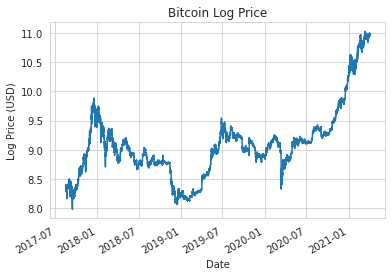

In [ ]:
# Plot the log price of Bitcoin in USD
ax = np.log(env.data_source.load_data()['close']).plot(title = 'Bitcoin Log Price', ylabel='Log Price (USD)', xlabel='Date')

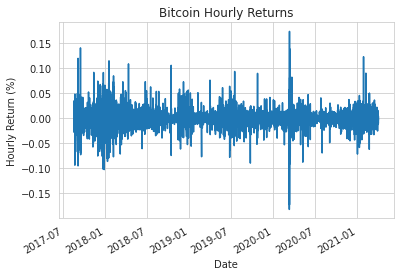

In [ ]:
# Bitcoin hourly returns
env.data_source.data['pct_change_1'].plot(title = 'Bitcoin Hourly Returns', ylabel='Hourly Return (%)', xlabel='Date');

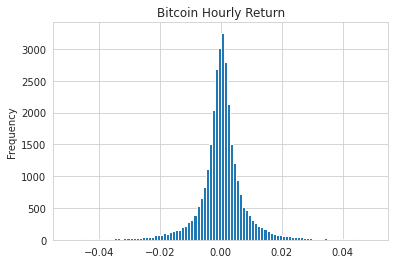

In [ ]:
# Bitcoin hourly returns histogram
env.data_source.data.pct_change_1.plot(kind='hist', bins=100, range=(-0.05, .05), title = 'Bitcoin Hourly Return', ylabel='Frequency', xlabel='Hourly Return (%)');

In [ ]:
# Get environment parameters
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n
max_episode_steps = env.max_episode_steps

In [ ]:
state_dim

12

### 2.4 Define Trading Agent

Next, we provide a brief overview of the relevant theoretical content and construct the `TradingAgent` class.


Q-learning was first developed by Chris Watkins for his PhD thesis and introduces incremental dynamic programming to learn to control an Markov Decision Process (MDP) [7]. The algorithm is model-free, as it does not model the transition and reward functions, and can handle problems with stochastic transitions and rewards. Q-learning learns the value of an action in a particular state and it finds an optimal policy which maximizes total expected reward over all successive steps from the current one. The algorithm proceeds off-policy, as it does not need to select actions based on the policy implied by the value function alone. Q-learning can identify an optimal policy for a given (MDP) provided a partly random policy and infinite exploration time. 

The Q-learning algorithm continually improves a state-action value function, $Q(s,a)$, for a given number of episodes. At each time step, it chooses an action based on a policy (we implement epsilon-greedy) and uses a learning rate to update the state-action value funtion. 


$Q(s,a) \leftarrow Q(s,a) + \alpha[R(s,a) +  \gamma \max_{a^\prime} Q(s^\prime,a^\prime) - Q(s,a)]$


The algorithm updates the state-action value based on the rewards observed ($R(s,a)$) for an action produced by our policy and the current estimate of the discounted values received by following an optimal policy thereafter (i.e. the value function for the next state). The parameters $\gamma$ and $\alpha$ are the discount and learning rates respectively. Q-learing thus is a bootstraping method as it uses an estimate of the state-action value function to improve the state-action value estimates. Q-learning is part of Temporal Difference Learning, a larger family of algorithms in which learning does not wait until the final reward for an episode is received. Instead, estimates are updated using intermediate states which are closer to the final reward.


For our trading agent Q-learning implementation, we use an epsilon greedy policy to ensure continual exploration of new actions whilst also exploiting the learning experience. An epsilon greedy policy selects an action randomly with a probability epsilon and the action with the highest state-action value otherwise. The parameter epsilon is decreased each step to encourage more exploration in the beginning and more exploitation towards the end.


Within a context of continuous states, we may approximate the optimal state-action value function using a neural network, which results in a Deep Q-network. The Deep Q-learning algorithm approximates the state-action value function by learning a set of weights $\theta$ of a multilayered Deep Q-network (DQN) that maps a state to action values. DeepMind introduced this technique in Playing Atari with Deep Reinforcement Learning [8].

The Deep Q-learning algorithm applies gradient descent on a loss function that computes the squared difference between the DQN's estimate of the target:

$y = \mathbf{E}[R(s,a) + \gamma \max_{a^\prime} Q(s^\prime,a^\prime;\theta|s,a)]$

With the estimate of the state-action value of the current state action pair ($Q(s,a;\theta$)) to learn the network parameters [5]:

$L(\theta)=(y-Q(s,a;\theta))^2$

Both the current state-action value estimate and target depend on the DQN weights. Rather than computing the full gradient, we use mini-batch gradient descent and update the weights $\theta$ at each time step. 


The neural network architecture we consider is composed of 4 Dense layers of size 64, 64, 64 and an output layer of size 3, all with a rectified linear unit (ReLU) activation function. The first three input layers are followed by Batch Normalisation layers and the third layer is followed in addition with a Random Dropout layer. The input size to the neural network is 12, which represents the environment described by past lagged market returns and various technical indicator values for the current time step. The output of the DQN is a vector of length three representing the predicted state-action values for taking a short position, neutral position or a long position (represented by indeces 0,1,2 respectively).

We use a ReLU activation function, which computes the activation as $g(z) = max(0,z)$ for a given activation $z$. The derivative is constant whenever the unit is active and allows us to overcome the vanishing gradient problem. 


Batch Normalization is used to speed up training time and prevent imbalanced weights in the network, which may contribute towards an exploding gradient. Batch Normalization is applied to layers in a network. It normalizes the output from the activation functions, multiplies the normalized output by an arbitrary parameter and adds another arbitrary parameter to the resulting product (both parameters are trainable and will be optimized during the training process).


As mentioned, we additionally use Dropout as a regularization technique to prevent overfitting. The key idea is to randomly drop units with their connections from the neural network during training to prevent overfitting. 


For gradient descent we use the Adam (Adaptive moment estimation) optimizer algorithm. Adam computes adaptive learning rates for each parameter using an exponential moving average of the gradient and squared gradients. This realizes the benefit from Adagrad of maintaining a per-parameter learning rate, but further incorporates the ability for the algorithm to be adaptive based on recent weights. 


The deep reinforcement learning community has made several improvements to the DQN architecture to make the learning process more efficient and improve the final result [9]. We adopt experience replay and Double Deep Q-Learning.


Experience replay saves the history of states, actions, rewards and next states observed throughout training and randomly samples mini-batches from this memory to train the weights $\theta$ at each time step. This technqiue reduces autocorrelation of samples trained on and increases sample efficiency. 

 
Q-learning is known to overestimate the state-action values, which can negatively affect the learning process and the resulting policy [10]. The Double Deep Q-learning algorithm decouples the estimation of state-action values from the selection of actions. It maintains two separate DQNs with different sets of weights. The weights of one network (online network) are used to select the best action and the weights of the other network (target network) are used to provide a corresponding state-action value estimate:


$y = \mathbf{E}[R(s,a) + \gamma Q(s^\prime,argmax_{a^{\prime}}Q(s^{\prime}, a, \theta);\theta^\prime)]$

We maintain a separate online and target network mapping a state into action values for each action in a single forward pass.

We implement a Double Deep Q-learning trading agent in the class `TradingAgent` below, which incorporates the theory presented above.

In [ ]:
class TradingAgent:
    """
    Implementing the Double Deep Q-learning trading agent with experience replay.
    """
    def __init__(self, state_dim,
                 n_actions,
                 learning_rate,
                 discount_rate,
                 eps_decay_episodes,
                 memory_replay_capacity,
                 nn_architecture,
                 l2_param,
                 tau,
                 batch_size):

        self.state_dim = state_dim                    # state of the environment
        self.n_actions = n_actions                    # number of actions available 
        # Deques have O(1) speed for appendleft() and popleft() while lists have O(n) performance for insert(0, value) and pop(0)
        self.experience = deque([], maxlen=memory_replay_capacity) # used to store the S,A,R,S_prime 
        self.learning_rate = learning_rate            # Rate at which state-action values are updated
        self.discount_rate = discount_rate            # Rate at which future rewards are discounted
        self.nn_architecture = nn_architecture        # The NN architecture given as a tuple of layer sizes
        self.l2_param = l2_param                      # L2 regularizer

        self.online_NN = self.construct_model()                 # neural network used to make action decisions
        self.target_NN = self.construct_model(trainable=False)  # the other network used to perform double deep-q learning
        self.update_target()

        # Parameters for epsilon decay implementation
        self.eps = 1
        self.eps_start = 1.0
        self.eps_end = 0.01
        self.eps_decay_episodes = eps_decay_episodes
        self.eps_decay = (self.eps_start - self.eps_end) / self.eps_decay_episodes
        self.eps_exponential_decay = .99
        self.eps_history = []

        self.total_steps = 0 
        self.episodes = 0

        self.batch_size = batch_size                # batch size used to train neural network
        self.tau = tau                              # frequency of updating target NN's weights to online NN's
        self.idx = tf.range(batch_size)

    def construct_model(self, trainable=True):
        """
        Function used to build the neural networks (NN) for the online and target network.
        returns a tf.keras.Model
        """
        layers = []
    
        for i, units in enumerate(self.nn_architecture, 1):                     # NN architecture is given as a tuple of number of neurons in each layer
            
            layers.append(Dense(units=units,                                    # dimensionality of the output space
                                input_dim=self.state_dim if i == 1 else None,   
                                activation='relu',                              # use Rectified Linear Unit as activation function
                                kernel_regularizer=l2(self.l2_param),           # adds the l2 regularization penalty to the loss wrt. the layer's weight
                                trainable=trainable))    
            layers.append(BatchNormalization())                                 # add a Batch Normalisation layer after each Dense layer

        layers.append(Dropout(.1))                                              # add Random Dropout before the final output layer
        layers.append(Dense(units=self.n_actions, trainable=trainable))         # final Dense layer representing state action values for each action
        model = Sequential(layers)
        model.compile(loss='mean_squared_error',
                      optimizer=Adam(lr=self.learning_rate))                    # use mean squared error loss funciton and Adam optimizer
        return model

    def update_target(self):
        # Set weights of target network to that of the online one
        self.target_NN.set_weights(self.online_NN.get_weights())

    def memorize_transition(self, s, a, r, s_prime, not_done):
        """
        Implements epsilon decay and memorizes the transition
        """
        self.experience.append((s, a, r, s_prime, not_done))                    # add to memory

        if not not_done:
            if self.episodes < self.eps_decay_episodes:                         # linearly decay epsilon during the first 'eps_decay_episodes' 
                self.eps -= self.eps_decay
            else:                
                self.eps *= self.eps_exponential_decay                          # after that, exponentially decay epsilon

            self.episodes += 1

    def experience_replay(self):
        """
        Takes a random minibatch from memory and implements the Double Deep Q-learning algorithm.
        Based on Stefan Jansen's Deep Reinforcement Learning Trading Agent (chp 22.) [5]
        """
        if self.batch_size > len(self.experience):
            return
        # The map() function executes a specified function for each item in an iterable.
        # we unpack the list with *
        minibatch = map(np.array, zip(*sample(self.experience, self.batch_size)))   # returns a map function
        states, actions, rewards, next_states, not_done = minibatch                 # use map function to get 4 np.arrays: one for 's', 'a', 'r', 's_prime'

        # Find the optimal action in the next state using the online NN
        next_q_val = self.online_NN.predict_on_batch(next_states)       # 'next_q_values' is an array of shape (4000, 3) representing q-values for each state given an action
        best_actions = tf.argmax(next_q_val, axis=1)                    # 'best_actions' is a tf.Tensor of shape (4000,0) representing the action with highest q-value

        # Find the q-value of the next state using the q-value given by the target network for the action previously chosen
        next_q_val_target = self.target_NN.predict_on_batch(next_states)
        target_q_val = tf.gather_nd(next_q_val_target,
                                       tf.stack((self.idx, tf.cast(best_actions, tf.int32)), axis=1)) # 'target_q_val' is a tensor of shape (4000,)

        targets = rewards + not_done * self.discount_rate * target_q_val # for final steps (when 'done'=True), the q-value is only the next reward

        q_val = self.online_NN.predict_on_batch(states)
        q_val[[self.idx, actions]] = targets

        loss = self.online_NN.train_on_batch(x=states, y=q_val) # update weights

        if self.total_steps % self.tau == 0:
            self.update_target()                                # occasionally update the target_network parameters                            


    def epsilon_greedy_policy(self, state):
        '''
        Returns action as a number 0 to 2.
        '''
        self.total_steps += 1
        if np.random.rand() <= self.eps:
            return np.random.choice(self.n_actions)     # with probability epsilon return a random action
        else:
            q = self.online_NN.predict(state)           # find Q-values for each action given the state
            return np.argmax(q, axis=1).squeeze()       # return action with highest Q-value

### 2.5 Train and Validate

#### 2.5.1 Set Parameters

In [ ]:
# Simulation parameters
total_steps = 0
max_episodes = 1000

# NN parameters
nn_architecture = (64, 64, 64)  # units per layer
learning_rate = 0.0001          # learning rate
l2_param = 0.000006             # L2 regularization
discount_rate = .99,            # discount factor
tau = 100                       # target network update frequency (steps)

# Experience Replay
memory_replay_capacity = int(1000000)
batch_size = 4000

# Epsilon Greedy Policy
eps_decay_episodes = int(max_episodes*0.8)

#### 2.5.2 Helper Functions


In [ ]:
def format_time(t):
    '''This helper function is from Stefan Jansen's 'Machine Learning for Algorithmic Trading' [5]'''
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return '{:02.0f}:{:02.0f}:{:02.0f}'.format(h, m, s)
    
    
def track_results(episode, agent_nav_10, market_nav_10, win_ratio, total_time, eps):
    ''' Print metrics of the training process '''
    template = f'\t\t{episode}\t | {format_time(total_time)}\t | Agent (last 10 episode avg. NAV): {round((agent_nav_10-1)*100,1)}% \t | Market (last 10 episode avg. NAV): {round((market_nav_10-1)*100,1)}% \t | Win ratio (last 100): {round(win_ratio*100,1)}% \t | Epsilon: {round(eps,2)}'
    print(template)

#### 2.5.3 Model Training and Evaluation

In [ ]:
tf.keras.backend.clear_session()

# Create the trading agent
trading_agent = TradingAgent(state_dim=state_dim,
                 n_actions=n_actions,
                 learning_rate=learning_rate,
                 discount_rate=discount_rate,
                 eps_decay_episodes=eps_decay_episodes,
                 memory_replay_capacity=memory_replay_capacity,
                 nn_architecture=nn_architecture,
                 l2_param=l2_param,
                 tau=tau,
                 batch_size=batch_size)

trading_agent.online_NN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                832       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

##### 2.5.3.1 Conduct Training with Agent and Random Policy

In [ ]:
# Initialize lists for recording simulation output
agent_navs, agent_diffs, agent_cumulative_rewards = [], [], []
random_navs, random_diffs = [], []
market_navs = []

start = time()

for episode in range(1, max_episodes + 1):
    this_state = env.reset()
    for episode_step in range(max_episode_steps):
        action = trading_agent.epsilon_greedy_policy(this_state.reshape(-1, state_dim))                 # implement epsilon greedy policy
        next_state, reward, done  = env.step(action)                                                    # take step in environment
    
        trading_agent.memorize_transition(this_state, action, reward, next_state, 0.0 if done else 1.0) # memorize past scenario 

        trading_agent.experience_replay()                                                               # implement experience replay

        if done:
            break

        this_state = next_state

    result = env.trading_logic.result()     # returns a df of results at each time step
    final = result.iloc[-1]                 # get the last row

    # Record NAVs (market, agent, random policy) after episode
    market_nav = final.market_nav
    market_navs.append(market_nav)
    agent_nav = final.agent_nav
    agent_navs.append(agent_nav)
    random_nav = final.random_nav
    random_navs.append(random_nav)

    # Record differences of performance of agent and random policy vs market after episode
    agent_diff = agent_nav - market_nav
    agent_diffs.append(agent_diff)
    agent_cumulative_rewards.append(final.agent_cumulative_reward)      # Also record the return/ cumulative reward of episode
    random_diff = random_nav - market_nav
    random_diffs.append(random_diff)


    if episode % 10 == 0:
        track_results(episode, np.mean(agent_navs[-10:]), np.mean(market_navs[-10:]), np.sum([s > 0 for s in agent_diffs[-100:]])/min(len(agent_diffs), 100), time() - start, trading_agent.eps)


# Store all recording variables
train_results = pd.DataFrame({'Episode': list(range(1, episode+1)),
                                    'Market': market_navs,
                                    'Agent': agent_navs,
                                    'Random_policy': random_navs,
                                    'Agent_diff': agent_diffs,
                                    'Random_diff': random_diffs,
                                    'Agent_cum_rewards': agent_cumulative_rewards,
                              }).set_index('Episode')

# Also calculate win ratios
train_results['Agent_win'] = (train_results.Agent_diff > 0).astype(int)
train_results['Random_win'] = (train_results.Random_diff > 0).astype(int)

		10	 | 00:00:02	 | Agent (last 10 episode avg. NAV): -31.5% 	 | Market (last 10 episode avg. NAV): 3.3% 	 | Win ratio (last 100): 0.0% 	 | Epsilon: 0.99


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


		20	 | 00:00:33	 | Agent (last 10 episode avg. NAV): -21.4% 	 | Market (last 10 episode avg. NAV): 4.6% 	 | Win ratio (last 100): 5.0% 	 | Epsilon: 0.98
		30	 | 00:01:47	 | Agent (last 10 episode avg. NAV): -23.1% 	 | Market (last 10 episode avg. NAV): 2.9% 	 | Win ratio (last 100): 3.3% 	 | Epsilon: 0.96
		40	 | 00:03:03	 | Agent (last 10 episode avg. NAV): -21.8% 	 | Market (last 10 episode avg. NAV): -1.2% 	 | Win ratio (last 100): 5.0% 	 | Epsilon: 0.95
		50	 | 00:04:21	 | Agent (last 10 episode avg. NAV): -24.5% 	 | Market (last 10 episode avg. NAV): 13.3% 	 | Win ratio (last 100): 4.0% 	 | Epsilon: 0.94
		60	 | 00:05:40	 | Agent (last 10 episode avg. NAV): -24.1% 	 | Market (last 10 episode avg. NAV): 0.2% 	 | Win ratio (last 100): 3.3% 	 | Epsilon: 0.93
		70	 | 00:07:02	 | Agent (last 10 episode avg. NAV): -28.0% 	 | Market (last 10 episode avg. NAV): -1.8% 	 | Win ratio (last 100): 2.9% 	 | Epsilon: 0.91
		80	 | 00:08:29	 | Agent (last 10 episode avg. NAV): -25.3% 	 | Market (

##### 2.5.3.2 Conduct Testing with Agent and Random Policy

In [ ]:
this_state = env.reset(train=False)         # reset environment in test mode (train=False)

for step in range(len(env.data_source.test_dataset)-1):
    action = trading_agent.epsilon_greedy_policy(this_state.reshape(-1, state_dim))
    next_state, reward, done = env.step(action, False)
    this_state = next_state

test_results = env.trading_logic.result()   # returns a df of results at each time step

In [ ]:
# Record train and test output by saving results in csv format
pd.DataFrame.from_dict(train_results).to_csv(f'{url}/Bitcoin_trading_DDQN_train_results.csv')
pd.DataFrame.from_dict(test_results).to_csv(f'{url}/Bitcoin_trading_DDQN_test_results.csv')

## 3. Results

### 3.1 Performance on Training Dataset

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, "Difference Between the Agent's NAV and the Market's after an epsiode")

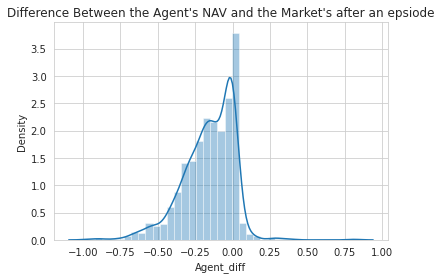

In [ ]:
sns.distplot(train_results.Agent_diff).set_title("Difference Between the Agent's NAV and the Market's after an epsiode")

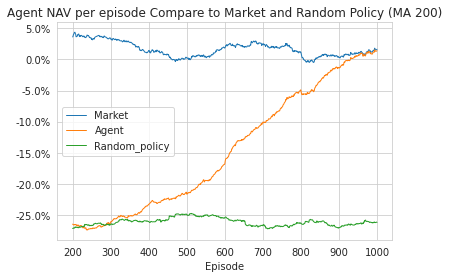

In [ ]:
df1 = ((train_results[['Market', 'Agent','Random_policy']].sub(1)*100).rolling(200).mean())
ax = df1.plot(title='Agent NAV per episode Compare to Market and Random Policy (MA 200)',lw=1)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

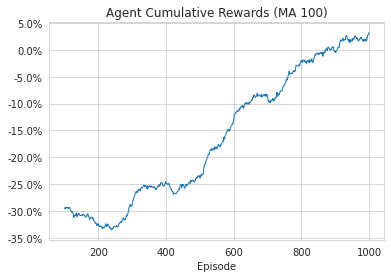

In [ ]:
ax = (train_results['Agent_cum_rewards']*100).rolling(100).mean().plot(title='Agent Cumulative Rewards (MA 100)',lw=1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

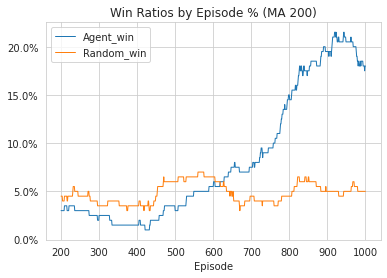

In [ ]:
ax = (train_results[['Agent_win', 'Random_win']]*100).rolling(200).mean().plot(title='Win Ratios by Episode % (MA 200)',lw=1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

From the above figures we see that the difference in NAV between the trading agent and the market buy-and-hold strategy after each episode whilst training is more often than not negative. However, the agent appears to often perform very close to the buy-and-hold strategy and sometimes over-performing it. The histogram of differences in NAV between the agent and the market are taken over all the episodes during training and therefore perhaps the density bars indicating zero difference or a slightly positive difference are contributed by the later episodes during training. Indeed, this hypothesis is supported by the figure plotting the 200 moving average returns of the market, trading agent and random policy across the episode iterations. Although the agent moving average never appears to consistently beat the market, it does learn to perform better throughout the episodes as noticed by increased NAV returns per episode. Towards the end, the agent even appears to perform on par with the market on average. This is contrary to the random policy, which of course maintains a fairly constant return per episode throughout the training process. Another metric indicating that the agent is learning to perform better on the training data is the win ratio of the agent compared to the market, benchmarked against the random policy's win ratio compared to the market. As expected, the win ratio of the agent against the market appears increasing throughout the episodes to a maximum of approximately 20% , unlike the random policy's win ratio which appears to stay flat at around 5%.

These results suggests that the agent is training the DDQN to learn from the environment, consisting of lagged returns and technical indicators, to place trades. Furthermore, this may be more explicitly seen from the figure above plotting the 100 moving average agent return (i.e. cumulative reward) across the episodes. 

Even though the agent is not able to consistently beat the market, the above results are interesting as they suggest that the agent is at least learning to perform better on the training dataset throughout the episodes. However, it is unclear as to whether the learning agent is merely overfitting the training data and memorising previously instances of the market. To discern this, we turn to the test dataset, which contains the last 30% of the data ending on 04/04/2021.

### 3.2 Performance on Testing Dataset

Text(0, 0.5, 'Net Asset Value')

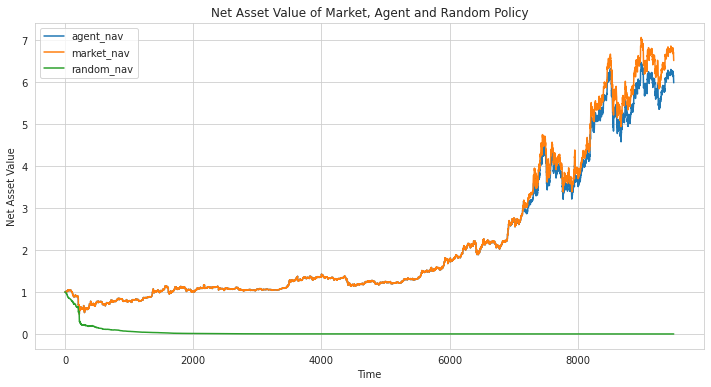

In [ ]:
ax = test_results[['agent_nav','market_nav','random_nav']].iloc[:-1,:].plot(figsize=(12, 6), title='Net Asset Value of Market, Agent and Random Policy')
ax.set_xlabel("Time")
ax.set_ylabel("Net Asset Value")

In [ ]:
print(f"Percentage of steps where made a new trade: {round((sum(test_results['agent_trade'].astype(bool))/len(test_results['agent_trade']))*100,2)} %")

Percentage of steps where made a new trade: 0.14 %


To address the agent's generalization skill and check whether the DDQN agent was overfitting the data, we let the agent trade against the market and a random policy on the hold out test set of Bitcoin's hourly price from approximately March 2020 to April 2021. From the above figure we see that the agent had chosen to follow a buy-and-hold strategy with very few trades implemented (traded on 0.14% of the training episode steps). It should be noted in subsequent implementations, the agent may not always find this same strategy. 


On initial reflection, it may appear that the agent had learnt to always implement a buy-and-hold strategy to maximise returns, which is consistent with the agent’s moving average NAV returns increasing to the market level during training, as seen before. However, if this where the case, then the agent would never ‘win’ the market, as it follows the market with an initial trading cost of taking the initial buy-and-hold position. Therefore, a policy of taking a buy-and-hold position in each training episode is inconsistent with the increased win ratio the agent is experiencing throughout training. Thus, the agent appears to utilise other strategies, besides a buy-and-hold, at least during training. 


During the the testing time series period from March 2020 and April 2021, Bitcoin's price had behaved extremely unconventionally, even in the cryptocurrency's own standards. The cryptocurrency saw an appreciation from approximately USD 10,000  to approximately USD 50,000. Therefore, it is unsurprising that a buy-and-hold strategy is adopted by the agent for the testing period. Perhaps in an environment where the price is volatile, but does not display an upwards trend, we would observe the trading agent conduct more trades and seek to profit from the price volatility. To test for such behaviour, one could use forward chaining k-fold cross validation. With this approach we could obtain multiple point estimates of the performance metrics over some folds which do not display any clear upwards price trend. Furthermore, to encourage active trading behaviour, which exploits the price volatility and not the upwards trend, one could implement another holding cost for not implementing a trade during a time step.


It is difficult to assess whether the agent has overfit on the training data by merely memorizing past seen market environments, as we have only one time series realization of the test set. Again, it would be beneficial to use forward chaining k-fold validation to get multiple point estimates of performance which we could use to compare against training performance. Such forward chaining k-fold validation would obviously increase the running time. To reduce the number of epochs required for k-fold validation and stabilise the network learning process, we could have normalized the data. If there is evidence of overfitting, we may increase the Dropout rate parameter as well as decrease the number of technical indicators. 


As our agent was not able to consistently beat the market return, the results are consistent with the weak form of the Efficient Market hypothesis, stipulating that past returns yield no signal towards future returns. It is important to note that this outcome merely fails to disprove the Efficient Market Hypothesis, but does not confirm its existence. Perhaps an alternative configuration of parameters, network architecture or new technical indicators would result in a trading agent outperforming the market on a risk adjusted basis. Or alternatively, the degree to which the EMH applies to the BTC/USD market varies throughout time, as noted to occur with stocks by Byrd and Balch [11]. Our results presented are inconclusive as to whether the BTC/USD operates according to the Efficient Market Hypothesis.



## 4. Conclusion

By building a Double Deep Q-learning trading agent in the BTC/USD market, and investigating if consistently over-performing the market is possible, we explore whether the EMH holds for this largely retail investor driven market. Our trading agent is shown to improve it's average performance with increased training episodes and reaches Net Asset Value returns close to the buy-and-hold strategy during training. 
When testing the agent, we find that the optimal strategy implemented by the agent is indeed the buy-and-hold strategy and therefore, our analysis does not demonstrate evidence against the EMH. It is important to note that this outcome merely fails to disprove the Efficient Market Hypothesis. Perhaps an alternative configuration of parameters, network architecture or new technical indicators would result in a trading agent outperforming the market on a risk adjusted basis. Moreover, the result is limited due to the fact that the testing time series data incorporated an unusual period of an upward trend in Bitcoin’s price. To further extend the analysis, one may implement forward chaining k-fold validation and as such test on alternative periods not characterised by such a strong upwards trend. In addition, data normalisation could be implemented to speed up the increased running time of k-fold validation. Such a validation technique would allow for a more accurate diagnosis of overfitting as well. The agent can be also further enhanced by allowing for continuous values of the proportion of the portfolio to be placed on a trade. A larger difference in estimated state-action values corresponds to a more 'confident' assessment of the future, which may be translated into larger trading position taken. 

## 5. References

[1] Samuelson, Paul (1965), "Proof That Properly Anticipated Prices Fluctuate Randomly". Industrial Management Review. 6: 41–49

[2] Fama, Eugene (1965), "The Behavior of Stock Market Prices". Journal of Business. 38: 34–105

[3] Fama, Eugene (1970), "Efficient Capital Markets: A Review of Theory and Empirical Work". Journal of Finance. 25 (2)

[4] Marwala, Tshilidzi; Hurwitz, Evan (2017) Artificial Intelligence and Economic Theory: Skynet in the Market. London: Springer

[5] Stefan Jansen - Machine Learning for Algorithmic Trading 2nd Edition, Packt

[6] Crypto Data Download, https://www.cryptodatadownload.com/data/binance/).

[7] Chris Watkins, Learning from Delayed Rewards, 1989 http://www.cs.rhul.ac.uk/~chrisw/new_thesis.pdf

[8] Mnih, Volodymyr; et al. (December 2013). Playing Atari with Deep Reinforcement Learning (PDF). NIPS Deep Learning Workshop 2013.

[9] Hessel et al 2017 'Rainbow: Combining Improvements in Deep Reinforcement Learning' https://arxiv.org/pdf/1710.02298.pdf

[10] van Hasselt, Hado; Guez, Arthur; Silver, David (2015). "Deep reinforcement learning with double Q-learning" (PDF). AAAI Conference on Artificial Intelligence: 2094–2100. 

[11] David Byrd, Tucker Hybinette Balch (2019). "Intra-day Equity Price Prediction using Deep Learning as a Measure of Market Efficiency", In journal submission